In [75]:
# Configuração do pandas
import pandas as pd

# Configuração do matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Sklearn e Skforecast
from sklearn.ensemble import RandomForestRegressor

!pip install skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [76]:
# Carrega Dados
url = 'https://raw.githubusercontent.com/michelrubens/seattle-weather/main/seattle-weather.csv'
data = pd.read_csv(url, sep = ',')
data = data.drop(['precipitation', 'wind', 'temp_min', 'weather'], axis=1)
data

,date,temp_max
0,2012-01-01,12.8
1,2012-01-02,10.6
2,2012-01-03,11.7
3,2012-01-04,12.2
4,2012-01-05,8.9
...,...,...
1456,2015-12-27,4.4
1457,2015-12-28,5.0
1458,2015-12-29,7.2
1459,2015-12-30,5.6


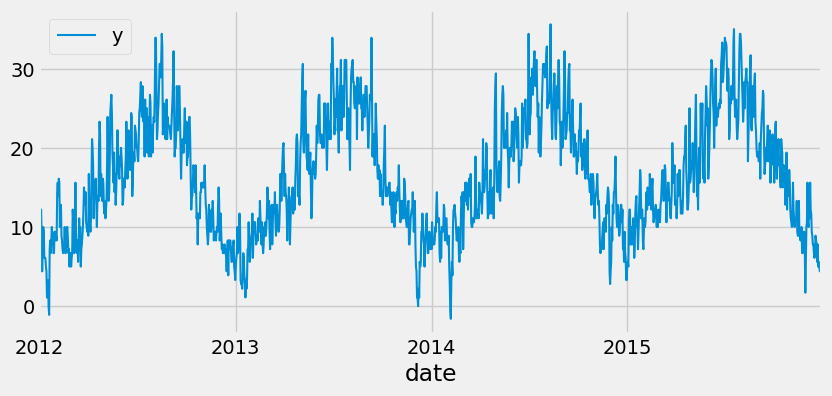

In [77]:
# Converte data de string para datetime e transforma em índice
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
# Seto o índice
data = data.set_index('date')
# Defino a frequência (Mensal). Caso falte registro, cria um novo e preenche as demais colunas com 0.0
data = data.asfreq('D', fill_value=0.0)
# Ordena pela data
data = data.sort_index()
# Plota os dados
fig, ax = plt.subplots(figsize=(9, 4))
data['temp_max'].plot(ax=ax, label='y')
# data['temp_min'].plot(ax=ax, label='exogenous variable')
ax.legend();

In [78]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [79]:
# Código para verificar se não existem "buracos" nos dados
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

Train dates : 2012-01-01 00:00:00 --- 2014-12-31 00:00:00  (n=1096)
Test dates  : 2015-01-01 00:00:00 --- 2015-12-31 00:00:00  (n=365)


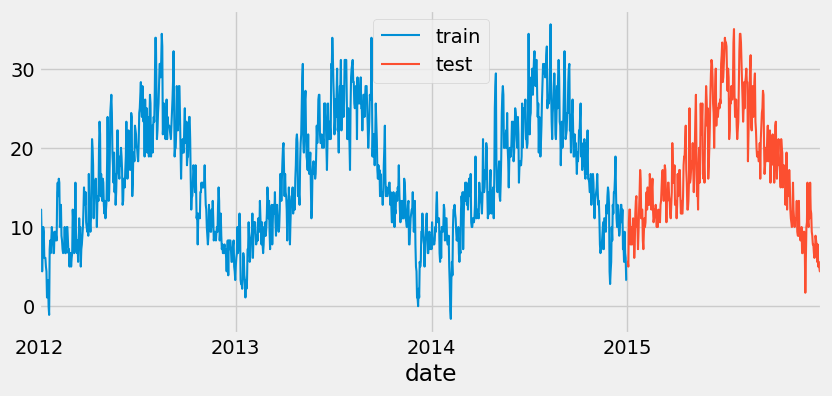

In [80]:
# Divide dados em treinamento e teste
# Para séries temporais, sempre utilizamos os dados mais recentes para teste
steps = 365
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Plotando os dados
fig, ax=plt.subplots(figsize=(9, 4))
data_train['temp_max'].plot(ax=ax, label='train')
data_test['temp_max'].plot(ax=ax, label='test')
ax.legend();

In [84]:
# Configura e treina um RandomForestRegressor para série temporal
# Os parâmetros foram retirados do melhor modelo encontrado no material de origem
# Para conseguir os melhores parâmetros se faz necessário realizer hyperparameter tunning (verifique artigo original)
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 365 # O valor será substituído durante o tunning
             )

forecaster.fit(y=data_train['temp_max'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 22

In [85]:
# Faz predição no conjunto de teste
steps = 365
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2015-01-01    2.223
2015-01-02    1.999
2015-01-03    2.850
2015-01-04    2.722
2015-01-05    3.589
Freq: D, Name: pred, dtype: float64

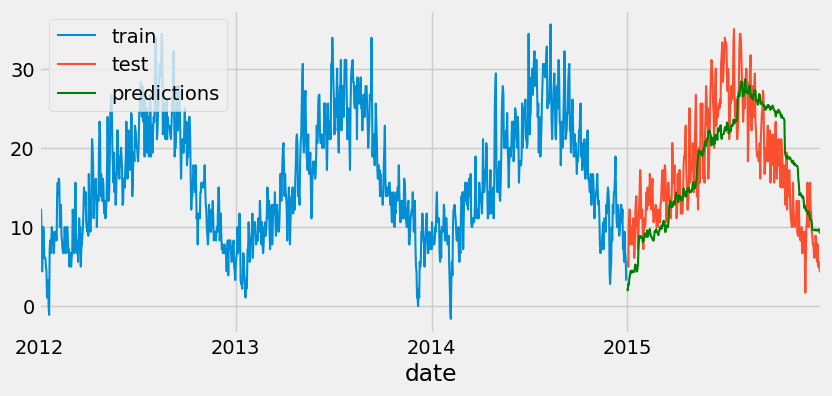

In [86]:
# Plota a predição, comparando com valores reais
fig, ax=plt.subplots(figsize=(9, 4))
data_train['temp_max'].plot(ax=ax, label='train')
data_test['temp_max'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions', color='green')
ax.legend();